#Run Simulation

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
path_to_save = 'figures/'
path_data = 'data/'

In [0]:
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):
    """
    Delays the input new_I_t by delay and return and array with length len_new_cases_obs
    The initial delay of the output is set by delay_arr. 
    
    Take care that delay is smaller or equal than delay_arr, otherwise zeros are 
    returned, which could potentially lead to errors

    Also assure that len_new_I_t is larger then len(new_cases_obs)-delay, otherwise it 
    means that the simulated data is not long enough to be fitted to the data.
    """
    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation


In [33]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time

date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,3,15)
num_days_to_predict = 28


diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = (date_data_end - date_begin_sim).days
date_today = date_data_end + datetime.timedelta(days=1)
# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)
    
    # -------------------------------------------------------------------------- #
    # prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_germany)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_no_change]), 
                                     len_new_I_t=diff_data_sim + num_days_to_predict, 
                                     len_new_cases_obs=num_days_to_predict, 
                                     delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_no_change', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # social distancing, m reduced by about 50 percent
    # -------------------------------------------------------------------------- #
    #For all following predictions:
    length_transient = 7  # days


    # λ is decreased by 50%
    reduc_factor_mild = 0.5
    days_offset = 0  # start the decrease in spreading rate after this

    time_arr = np.arange(num_days_to_predict)

    # change in m along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_soc_dist= λ * (1 - λ_correction * reduc_factor_mild) 

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_soc_dist = SIR_model(λ=λ_t_soc_dist, μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_germany)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_soc_dist]), 
                                    len_new_I_t=diff_data_sim + num_days_to_predict, 
                                    len_new_cases_obs=num_days_to_predict, 
                                    delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_soc_dist', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation 5 days later, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol_later= λ * (1 - λ_correction * reduc_factor_strong) 

    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    forecast_isol_later = SIR_model(λ=λ_t_isol_later, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later

    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol_later]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol_later', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # isolation 5 days earlier, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    length_transient = 7

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset, num_days_to_predict)

    # change in λ along time

    λ_t_earlier  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset]
    I_begin = I_past[-1 + days_offset]
    forecast_earlier = SIR_model(λ=λ_t_earlier, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_earlier, I_earlier, new_I_earlier = forecast_earlier

    pm.Deterministic('S_earlier', S_earlier)
    pm.Deterministic('I_earlier', I_earlier)  
    pm.Deterministic('new_I_earlier', new_I_earlier)
    pm.Deterministic('λ_t_earlier', λ_t_earlier)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset], new_I_earlier]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    
    pm.Deterministic('new_cases_earlier', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # long transient scenario
    # -------------------------------------------------------------------------- #

    length_transient = 14

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -3.5  # start the decrease in spreading rate after this
    days_offset_sim = -4

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset_sim, num_days_to_predict)

    # change in λ along time

    λ_t_long_trans  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset_sim]
    I_begin = I_past[-1 + days_offset_sim]
    forecast_long_trans = SIR_model(λ=λ_t_long_trans, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_long_trans, I_long_trans, new_I_long_trans = forecast_long_trans

    pm.Deterministic('S_long_trans', S_long_trans)
    pm.Deterministic('I_long_trans', I_long_trans)  
    pm.Deterministic('new_I_long_trans', new_I_long_trans)
    pm.Deterministic('λ_t_long_trans', λ_t_long_trans)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset_sim], new_I_long_trans]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_long_trans', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # immediate transient scenario
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 3.5 # start the decrease in spreading rate after this
    length_transient = 0.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_immedi', S_isol)
    pm.Deterministic('I_immedi', I_isol)  
    pm.Deterministic('new_immedi', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_immedi', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    time_beg = time.time()
    trace = pm.sample(draws=3000, tune=800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

Cases yesterday (2020-03-15): 5795 and day before yesterday: 4585


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_obs, delay, μ, λ, I_begin]
100%|██████████| 3800/3800 [02:18<00:00, 27.53it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


Model run in 292.75 s


#Plotting 

effective m: 1.278 +- 0.044


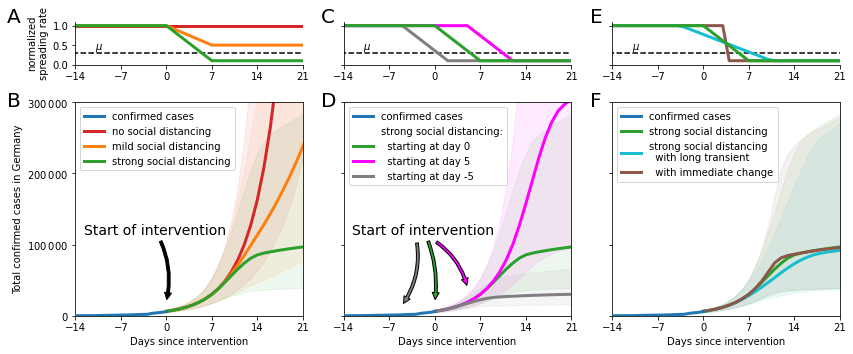

In [25]:
legends_lang = {
    "english": [
        # bottom left
        "confirmed cases",
        [
            "no social distancing",
            "mild social distancing",
            "strong social distancing",
            "strong social distancing since 5 days ago",
        ],
        "Days since intervention",
        "Total confirmed cases in Germany",
        "Start of intervention",
        # bottom right
        'confirmed cases',['strong social distancing:',
                           '  starting at day 0', 
                           '  starting at day 5',
                           "  starting at day -5"],
        'Days since intervention',
        'Total confirmed cases in Germany',
        'Start of intervention',
        "normalized\nspreading rate",
        ['strong social distancing',
         'strong social distancing\n  with long transient', 
         '  with immediate change'],
    ],
}

obs_cases_labels = ['new_cases_no_change', 'new_cases_soc_dist', 
                    'new_cases_isol', 'new_cases_isol_later','new_cases_earlier', 
                    'new_cases_long_trans','new_cases_immedi']


cases_obs_to_plot = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', date_formatted_begin:date_formatted_end])[0]
cases_obs_to_plot_future = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Germany', date_formatted_end:])[0]


def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = np.cumsum(trace[label], axis=1) + \
        np.sum(trace.new_cases_past, axis=1)[:, None] + cases_obs[0]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

obs_cases_labels_local = obs_cases_labels[:]
obs_cases_labels_local.pop(3)

for lang, legends_list in legends_lang.items():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[12, 6],gridspec_kw={'width_ratios': [1, 1,1]})

    # bottom left
    colors = ["tab:red", "tab:orange", "tab:green"]
    dict_obsc_cases = return_obs_cases_future(trace)
    ax = axes[1, 0]

    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[0], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)

    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_obsc_cases[label]
        # cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)

        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(0, 300_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[2])
    ax.set_ylabel(legends_list[3])
    # ax.locator_params(axis='y', nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.text(-0.3, 0.98, "B", transform=ax.transAxes, size=20)

    ax.annotate(
        legends_list[4],
        xy=(0.0, 20_000),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc="black"
        ),
    )

    # bottom middle
    ax = axes[1, 1]
    colors = ["tab:green", "fuchsia", 'gray']
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)

    dict_obsc_cases = return_obs_cases_future(trace)
    ax.plot([], [], alpha=0, label=legends_list[6][0])
    for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[6][1:]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        #cases = np.concatenate([np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0)
        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(0, 300_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    #ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.tick_params(labelleft=False)    

    ax.text(-0.1, 0.98, "D", transform=ax.transAxes, size=20)

    ax.annotate(
        legends_list[9],
        xy=(0.0, 20_000),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.15", fc=colors[0]
        ),
    )
    ax.annotate(
        "",
        xy=(5.0, 40_000),
        xycoords="data",
        xytext=(0.4, 0.35),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[1]
        ),
    )

    ax.annotate(
        "",
        xy=(-5.0, 15_000),
        xycoords="data",
        xytext=(0.32, 0.35),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[2]
        ),
    )

    # bottom right
    ax = axes[1, 2]
    colors = ["tab:green", "tab:cyan", 'tab:brown']
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)

    dict_obsc_cases = return_obs_cases_future(trace)
    for label, color, legend in zip([obs_cases_labels[2], obs_cases_labels[-2], obs_cases_labels[-1]], 
                                    colors, legends_list[11]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        #cases = np.concatenate([np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0)
        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(0, 300_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    #ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.tick_params(labelleft=False)    

    ax.text(-0.1, 0.98, "F", transform=ax.transAxes, size=20)

    # top left
    ax = axes[0, 0]

    m = np.median(trace.λ)
    decrease_in = 7  # days
    time = np.arange(-14, 22)
    m_correction = np.clip(time / decrease_in, 0, 1)
    reduction_fact_strong = 0.9
    reduction_fact_mild = 0.5

    ax.plot(time, np.ones_like(time), linewidth=3, color="tab:red")
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_mild),
        linewidth=3,
        color="tab:orange" )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong),
        linewidth=3,
        color="tab:green" )
    ax.hlines(np.median(trace.μ/trace.λ),-50,50, linestyles='--',label='critical point')
    #ax.legend()

    ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.set_ylim(0, 1.1)
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_xlim(-14, 21)
    ax.set_aspect(6, adjustable="box")
    ax.text(-0.3, 0.98, "A", transform=ax.transAxes, size=20)
    ax.text(-11, 0.4, "$\mu$", transform=ax.transData, size=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    # top middle
    ax = axes[0, 1]

    m = np.median(trace.λ)
    length_transient = 7  # days
    time = np.arange(-14, 22)
    
    reduc_factor_mild = 0.9
    days_offset_mild = -5  # start the decrease in spreading rate after this
    reduc_factor_strong = 0.9
    days_offset_strong = 5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_t1  = np.clip((time-days_offset_mild) / length_transient, 0, 1)*\
                      ((1-reduc_factor_mild) - 1) + 1
    λ_t2  = np.clip((time-days_offset_strong) / length_transient, 0, 1)*\
                      ((1-reduc_factor_strong) - 1) + 1

    #ax.plot(time, np.ones_like(time), linewidth=3, color="tab:red", label="no change")
    
    ax.plot(
        time,
        (λ_t2),
        linewidth=3,
        color="fuchsia",
    )
    ax.plot(
        time,
        (λ_t1),
        linewidth=3,
        color="gray",
    )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong),
        linewidth=3,
        color="tab:green",
    )
    ax.hlines(np.median(trace.μ/trace.λ),-50,50, linestyles='--',label='critical point')
    #ax.legend()

    #ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #ax.set_yticks([0, 0.5, 1.0])
    ax.tick_params(labelleft=False)    
    ax.set_ylim(0, 1.1)
    ax.set_xlim(-14, 21)
    ax.set_aspect(6, adjustable="box")
    ax.text(-0.1, 0.98, "C", transform=ax.transAxes, size=20)
    ax.text(-11, 0.4, "$\mu$", transform=ax.transData, size=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # top right
    ax = axes[0, 2]

    m = np.median(trace.λ)
    length_transient1 = 14  # days
    length_transient2 = 0.5
    time = np.arange(-14, 22)
    reduc_factor_mild = 0.9
    days_offset_mild = -3.5  # start the decrease in spreading rate after this

    reduc_factor_strong = 0.9
    days_offset_strong = 3.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_t1  = np.clip((time-days_offset_mild) / length_transient1, 0, 1)*\
                      ((1-reduc_factor_mild) - 1)+1
    λ_t2  = np.clip((time-days_offset_strong) / length_transient2, 0, 1)*\
                      ((1-reduc_factor_strong) - 1)+1

    #ax.plot(time, np.ones_like(time), linewidth=3, color="tab:red", label="no change")
    
    ax.plot(
        time,
        λ_t2,
        linewidth=3,
        color="tab:brown",
    )
    ax.plot(
        time,
        (λ_t1),
        linewidth=3,
        color="tab:cyan",
    )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong),
        linewidth=3,
        color="tab:green",
    )

    ax.hlines(np.median(trace.μ/trace.λ),-50,50, linestyles='--',label='critical point')
    #ax.legend()

    #ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.tick_params(labelleft=False)    
    ax.set_ylim(0, 1.1)
    ax.set_xlim(-14, 21)
    ax.set_aspect(6, adjustable="box")
    ax.text(-0.1, 0.98, "E", transform=ax.transAxes, size=20)
    ax.text(-11, 0.4, "$\mu$", transform=ax.transData, size=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # wrapping up
    fig.subplots_adjust(hspace=-0.50)
    fig.subplots_adjust(wspace=-.1)
    fig.tight_layout()
    fig.savefig(
        path_to_save + "Fig_2.png".format(lang), dpi=300
    )

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.λ - trace.μ), np.std(trace.λ - trace.μ)))

# 

# Figs joined


3008.147247540651
(25, 25)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:227: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


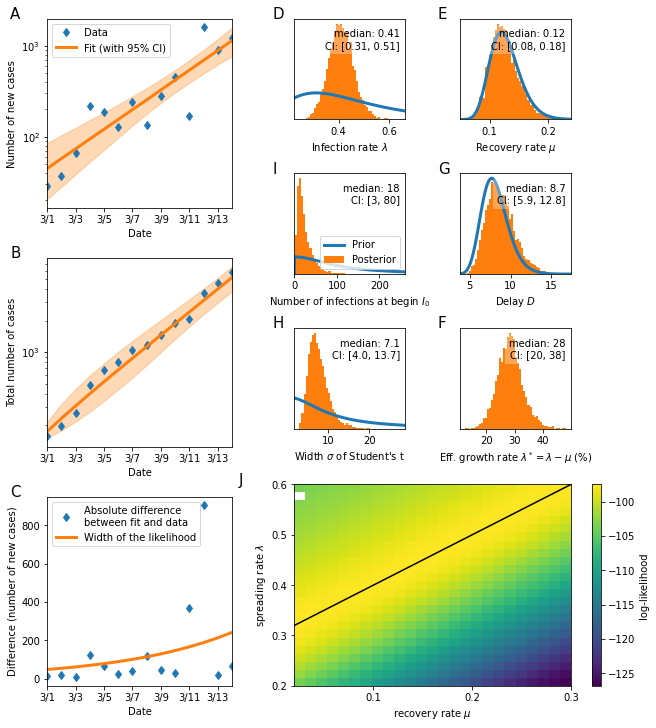

In [32]:
def truncate_number(number, precision):
    number = round(number, ndigits = precision)
    #number = round(number - number%(10**(-precision)),10)
    if precision == 0:
        number = int(round(number))
    return str(number)

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    #print('The 95% CI of {} is [{:.3f} , {:.3f}] with a median of {:.3f}'.format(label, med, perc1, perc2))
    return 'median: {}\nCI: [{}, {}]'.format(med, perc1, perc2)

def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_data_end for date in arr])

#Definitions
letter_size = 15
ci_location = [0.95,0.9]
alpha_texbox = 0.3
font_text = 10

#Making all square for simplicity
len1 = 5
len2 = 3

fig = plt.figure(figsize=(9,10),constrained_layout=True)
gs = fig.add_gridspec(15,11)

ax_cases_new = fig.add_subplot(gs[0:len1,0:len1])
ax_cases_total = fig.add_subplot(gs[len1:2*len1,0:len1])
ax_error = fig.add_subplot(gs[2*len1:3*len1,0:len1])

ax_param_infection  = fig.add_subplot(gs[0:len2,len1:len1+len2])
ax_param_recovery = fig.add_subplot(gs[0:len2,len1+len2:len1+2*len2])

ax_param_izero = fig.add_subplot(gs[len2:2*len2,len1:len1+len2])
ax_param_delay = fig.add_subplot(gs[len2:2*len2,len1+len2:len1+2*len2])

ax_param_width = fig.add_subplot(gs[2*len2:3*len2,len1:len1+len2])
ax_param_effective_rate = fig.add_subplot(gs[2*len2:3*len2,len1+len2:len1+2*len2])

ax_likelihood = fig.add_subplot(gs[3*len2:3*len1,len1:len1+2*len2])

#Plots things
pos_letter = (-0.2, 1)

ax = ax_cases_new
time = np.arange(-len(cases_obs)+1, 0)
mpl_dates = conv_time_to_mpl_dates(time) 
start_date, end_date = mpl_dates[0], mpl_dates[-1]
ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=6, label='Data')
percentiles = np.percentile(trace.new_cases_past, q=2.5, axis=0), np.percentile(trace.new_cases_past, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(trace.new_cases_past, axis=0),color='tab:orange', label='Fit (with 95% CI)', lw=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
ax.set_yscale('log')
ax.set_ylabel('Number of new cases')
ax.set_xlabel('Date')
ax.legend()
ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=letter_size)
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
ax.set_xlim(start_date, end_date)

ax = ax_cases_total
ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=6, label='Data')
cum_cases = np.cumsum(trace.new_cases_past, axis=1) + cases_obs[0]
percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', label='Fit (with 95% CI)', lw=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
ax.set_yscale('log')
ax.set_ylabel('Total number of cases')
ax.set_xlabel('Date')
#ax.legend()
ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=letter_size)
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
ax.set_xlim(start_date, end_date)

ax = ax_error
ax.plot(mpl_dates, np.abs(np.median(trace.new_cases_past, axis=0) - np.diff(cases_obs)), 
        'd', markersize=6,
         label='Absolute difference\n'
               'between fit and data')
ax.plot(mpl_dates, np.sqrt(np.median(trace.new_cases_past, axis=0))*np.median(trace.σ_obs, axis=0),
         label='Width of the likelihood', lw=3)
ax.set_ylabel('Difference (number of new cases)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
print(np.median(np.sum(trace.new_cases_past[:, :-2], axis=1)+ trace.I_begin))
ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=letter_size)
#plt.tight_layout()
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
ax.set_xlim(start_date, end_date)
plt.savefig(path_to_save + 'check_fit_composed.png', dpi=300)

ax = ax_param_infection
ax.hist(trace.λ, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Infection rate $\lambda$')
text = print_median_CI(trace.λ, prec=2)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=letter_size)
#ax.legend(loc='upper right')

ax = ax_param_recovery
ax.hist(trace.μ, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.μ, prec=2)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=letter_size)
#ax.legend(loc='upper right')

ax = ax_param_effective_rate
ax.locator_params(nbins=5)
#bins = np.linspace(-0.11, 0.304, 200)
ax.hist((trace.λ - trace.μ)*100, bins=50, color='tab:orange')
ax.set_xlabel('Eff. growth rate $\lambda^* = \lambda - \mu$ (%)')#\n'
          #'inferred from data - from {} to {}'.format(date_data_begin.isoformat(), 
          #                                            date_data_end.isoformat()))
ax.set_ylabel('Number of Monte-Carlo samples')
text = print_median_CI((trace.λ - trace.μ)*100, prec=0)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=letter_size)

ax = ax_param_delay
ax.hist(trace.delay, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='upper right')
ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=letter_size)

ax = ax_param_width
ax.hist(trace.σ_obs, bins=50, color='tab:orange', density=True, label='Posterior')
ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$ of Student's t")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.σ_obs, prec=1)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='upper right')
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=letter_size)

ax = ax_param_izero
ax.hist(trace.I_begin, bins=50, color='tab:orange', density=True, label='Posterior')
ax.set_ylabel('Density')
ax.set_xlabel('Number of infections at begin $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color='tab:blue', linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.legend(loc='lower right')
ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=letter_size)

ax = ax_likelihood
ax.locator_params(nbins=5)
μ_arr = np.linspace(0.02, 0.3, 25)
#λ_arr = np.linspace(0.2, 0.6, 25)
matrix = pickle.load(open(path_data + 'likelihood_matrix.pickled', 'rb'))
#matrix has [i,j] = [lambda,mu] with i rows -> rows for imshow are y
#so mu is on x axis...as we want to
im_mat = []
print(matrix.shape)
for row in matrix:
    im_mat.append([])
    for elem in row:
        if elem is not None:
            im_mat[-1].append(elem['logp'])
        else: im_mat[-1].append(np.nan)
#fig, ax1 = plt.subplots(1,1)
#im = ax1.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6], aspect=0.5)
#plt.colorbar()
#heatmap = ax.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6], aspect=0.71)
#heatmap = ax.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6])
heatmap = ax.imshow(im_mat,origin='lower',extent=[0.02, 0.3, 0.2, 0.6], aspect='auto')
pos = ax.get_position()
#cbaxes = fig.add_axes([0.43, pos.y0, 0.02, pos.y1-pos.y0])
#cbar = fig.colorbar(heatmap, cbaxes)
#cbar.set_label('log-likelihood')
ax.plot(μ_arr, μ_arr+0.30, color='black')
cbar = plt.colorbar(heatmap)
cbar.set_label('log-likelihood')
ax.set_ylabel('spreading rate $\lambda$')
ax.set_xlabel('recovery rate $\mu$')
ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=letter_size)
#ax.set_anchor('NW')

#Removes ylabels from D-I
ax_params = [ax_param_infection,ax_param_recovery, ax_param_effective_rate, ax_param_delay,ax_param_width,ax_param_izero]
for ax in ax_params:
  ax.set_yticks([], [])
  ax.set_ylabel('')

#gs.update(wspace=0.9, hspace=0.9)
#gs.update()
#plt.tight_layout()

plt.savefig(path_to_save+'Fig1_WIP.png')